In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf

import xgboost as xgb
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

import time
import datetime
from dateutil.parser import parse
from sklearn.decomposition import PCA, IncrementalPCA
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_1.csv', '20190103_2.csv', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', '20190218.csv', '20190219.csv', 'accurate.xlsx', 'comments.txt', 'cst1.csv', 'cst2.csv', 'document.csv', 'dot.csv', 'dot_1.csv', 'dot_result.csv']


In [52]:
dot_data_cst1 = pd.read_csv(path + 'cst1.csv', header = None, names = ['order_date', 'dot', 'company', 'order_num'])
dot_data_cst2 = pd.read_csv(path + 'cst2.csv', header = None, names = ['order_date', 'dot', 'company', 'order_num'])

In [53]:
dot_data_cst = pd.concat([dot_data_cst1, dot_data_cst2], ignore_index = True)
dot_data_cst['order_date'] = [str(x)[0:4] +'-'+ str(x)[4:6] +'-'+ str(x)[6:] for x in dot_data_cst['order_date']]
dot_data_cst['order_date'] = pd.to_datetime(dot_data_cst['order_date'])

In [54]:
dot_data_cst = dot_data_cst[dot_data_cst['order_date'] >= pd.to_datetime('2017-12-01')]
dot_data_cst = dot_data_cst[dot_data_cst['order_date'] <= pd.to_datetime('2019-01-31')]
dot_data_cst.head()

,order_date,dot,company,order_num
43,2017-12-28,南苑大红门点部,北京卓创仓库,1
47,2017-12-13,黄埔火村点部,广州嘉诺,3
51,2017-12-21,北仑镇海点部,宁波onlycook,2
56,2017-12-28,潮汕汕头点部,福清宏港,1
73,2017-12-21,顺德杏坛点部,佛山东立实业,5


In [55]:
dot_data_cst[dot_data_cst['dot'] == '相城洋沟娄点部'].sort_values('order_num',ascending = False).head(10)

,order_date,dot,company,order_num
5977844,2018-11-12,相城洋沟娄点部,苏州怡阳,9983
8552765,2018-11-11,相城洋沟娄点部,苏州怡阳,8270
5280879,2018-09-23,相城洋沟娄点部,苏州怡阳,7712
5563241,2018-11-13,相城洋沟娄点部,苏州怡阳,7021
13055783,2018-09-22,相城洋沟娄点部,苏州怡阳,5426
14134592,2018-06-05,相城洋沟娄点部,苏州赤豪牛排,5390
13952479,2018-07-08,相城洋沟娄点部,苏州骏德牛排,5068
12488740,2018-07-28,相城洋沟娄点部,苏州赤豪牛排,4722
8149526,2018-06-03,相城洋沟娄点部,苏州赤豪牛排,4700
5714226,2018-09-24,相城洋沟娄点部,苏州怡阳,4614


In [56]:
len(dot_data_cst['dot'].unique())

4608

### 一家公司同一天超过25票，赋1处理

In [57]:
dot_data_cst.loc[dot_data_cst['order_num'] > 25, ['order_num']] = 1

In [58]:
dot_data_cst.sort_values(by = 'order_num', ascending = False).head()

,order_date,dot,company,order_num
5736324,2018-11-10,江东永安点部,杭州梵深卫浴,25
4156921,2017-12-06,顺义点部,北京赛多利斯,25
6391112,2018-03-21,嘉善南湖点部,嘉兴润合美,25
13846051,2019-01-27,潮汕两英点部,汕头兴吉利发,25
6020780,2018-11-14,扬州西湖点部,扬州扬杰,25


In [59]:
dot_data_cst_tmp = dot_data_cst.drop(['company'], axis = 1)
dot_data_cst_tmp.head()

,order_date,dot,order_num
43,2017-12-28,南苑大红门点部,1
47,2017-12-13,黄埔火村点部,3
51,2017-12-21,北仑镇海点部,2
56,2017-12-28,潮汕汕头点部,1
73,2017-12-21,顺德杏坛点部,5


In [60]:
dot_groupby = dot_data_cst_tmp.groupby(['dot', 'order_date']).sum()
dot_groupby.reset_index(inplace = True)

In [61]:
dot_groupby.head()

,dot,order_date,order_num
0,大岭山执御点部,2018-11-13,23
1,大岭山执御点部,2018-11-14,1
2,ERP客户系统组,2017-12-02,1
3,IT南山中心组,2018-04-19,2
4,三水乐平点部,2018-05-17,5


In [62]:
data_count = pd.DataFrame(dot_groupby['order_date'].groupby(dot_groupby['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 400, ['dot']]
len(useful_dot_name)
# useful_dot_name.head()

648

In [63]:
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(useful_dot_name['dot']):
    one_dot = dot_groupby.loc[dot_groupby['dot'] == dot]
    one_dot = one_dot.loc[one_dot["order_date"] >= pd.to_datetime('2017-12-01')]
    num_median = np.median(one_dot['order_num'])
    ts = pd.date_range('2017-12-01', '2019-01-31')
    df_ts = pd.DataFrame(ts, columns = ['order_date'])
    df_ts['dot'] = dot
    df_ts['dot_id'] = i + 1
    merge_res = pd.merge(df_ts, one_dot, how= 'left')
#     merge_res = merge_res.loc[merge_res["order_date"] >= pd.to_datetime('2017-12-01')]
    merge_res['order_num'].fillna(num_median, inplace = True)
    if len(merge_res) >= 400:
        dot_preprocessing = pd.concat([dot_preprocessing, merge_res], axis = 0,ignore_index = True)

In [64]:
dot_preprocessing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276696 entries, 0 to 276695
Data columns (total 4 columns):
order_date    276696 non-null datetime64[ns]
dot           276696 non-null object
dot_id        276696 non-null int64
order_num     276696 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 8.4+ MB


In [65]:
dot_preprocessing['order_date'].groupby(dot_preprocessing['dot']).count().describe()

count    648.0
mean     427.0
std        0.0
min      427.0
25%      427.0
50%      427.0
75%      427.0
max      427.0
Name: order_date, dtype: float64

In [66]:
dot_prep = dot_preprocessing.copy()
dot_prep['order_num'] = np.log1p(dot_prep['order_num'])
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.head()

,order_date,dot,dot_id,order_num
0,2017-12-01,上虞上浦点部,1,2.639057
203679,2017-12-01,盛泽莘塔点部,478,2.639057
204106,2017-12-01,盛泽邱舍点部,479,3.178054
23058,2017-12-01,华强北福华点部,55,3.258097
204533,2017-12-01,盛泽震泽点部,480,3.332205


In [67]:
len(dot_prep)

276696

In [68]:
dot_info = pd.read_csv(path + 'dot.csv', header = None, names = ['dot', 'dot_type', 'area', 'city_code', 'department', 'province', 'city', 'district', 'town', 'village'])

In [69]:
dot_info.head()

,dot,dot_type,area,city_code,department,province,city,district,town,village
0,清江新下塘点部,大点部,华东,577,清江操作部,浙江省,温州市,乐清市,城东街道,新下塘村
1,香洲洪湾点部,大点部,华南,756,香洲操作部,广东省,珠海市,香洲区,南屏镇,洪湾社区
2,贵阳三甫点部,大点部,华北,851,贵阳操作部,贵州省,贵阳市,观山湖区,金华镇,三甫村
3,镇江大港点部,大点部,华东,511,镇江操作部,江苏省,镇江市,镇江新区,大路镇,大路村
4,三水竹山点部,大点部,华南,757,三水操作部,广东省,佛山市,三水区,乐平镇,竹山村


In [70]:
dot_data = pd.merge(dot_info, dot_prep, how = 'left', on = 'dot')
dot_data.head()

,dot,dot_type,area,city_code,department,province,city,district,town,village,order_date,dot_id,order_num
0,清江新下塘点部,大点部,华东,577,清江操作部,浙江省,温州市,乐清市,城东街道,新下塘村,NaT,NaN,NaN
1,香洲洪湾点部,大点部,华南,756,香洲操作部,广东省,珠海市,香洲区,南屏镇,洪湾社区,NaT,NaN,NaN
2,贵阳三甫点部,大点部,华北,851,贵阳操作部,贵州省,贵阳市,观山湖区,金华镇,三甫村,NaT,NaN,NaN
3,镇江大港点部,大点部,华东,511,镇江操作部,江苏省,镇江市,镇江新区,大路镇,大路村,2017-12-01,580.0,2.564949
4,镇江大港点部,大点部,华东,511,镇江操作部,江苏省,镇江市,镇江新区,大路镇,大路村,2017-12-02,580.0,2.639057


In [71]:
dot_data.loc[dot_data['city'].isnull(), ['city']] = dot_data.loc[dot_data['city'].isnull(), ['province']].values
dot_data.loc[dot_data['district'].isnull(), ['district']] = dot_data.loc[dot_data['district'].isnull(), ['city']].values

In [72]:
dot_data.dropna(axis = 0, inplace = True)
dot_data.sort_values(by = 'order_date', ascending = True, inplace = True)

In [73]:
dot_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275842 entries, 3 to 277837
Data columns (total 13 columns):
dot           275842 non-null object
dot_type      275842 non-null object
area          275842 non-null object
city_code     275842 non-null int64
department    275842 non-null object
province      275842 non-null object
city          275842 non-null object
district      275842 non-null object
town          275842 non-null object
village       275842 non-null object
order_date    275842 non-null datetime64[ns]
dot_id        275842 non-null float64
order_num     275842 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(9)
memory usage: 29.5+ MB


In [74]:
def time_feature(data):
    # 时间
    dot_prep_1 = data.copy()
    
    dot_prep_1['year'] = dot_prep_1.order_date.dt.year
    dot_prep_1['month'] = dot_prep_1.order_date.dt.month
    dot_prep_1['day'] = dot_prep_1.order_date.dt.day
    dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
    dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
    dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
    weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep_1['order_date'].unique())/7), freq = 'W-SUN')
    dot_prep_1['weekofsun'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
    dot_prep_1['holidays'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    return dot_prep_1

def create_feature(data):
    dot_prep_1 = time_feature(data)
    dot_prep_ts = data.copy()
    dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
    
    dot_prep_2 = pd.DataFrame()
    dot_prep_3 = pd.DataFrame()
    for dot in useful_dot_name['dot']:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        dot_ts.sort_index(ascending = True, inplace = True)
        # lagging
        lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
        lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
        lagging['dot'] = dot
        lagging['order_date'] = dot_ts.index
        lagging.dropna(axis = 0, inplace = True)
        dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
        
        # rolling
        rolling = pd.concat([dot_ts.rolling(window = 3).mean(), dot_ts.rolling(window = 5).mean(), dot_ts.rolling(window = 7).mean()], axis = 1)
        rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling.dropna(axis = 0, inplace = True)
        dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
    dot_prep_2.reset_index(drop = True, inplace = True)
    dot_prep_3.reset_index(drop = True, inplace = True)
    
    # merge
    dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
    dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
    dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
#     dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)
    
    return dot_prep_result

In [75]:
dot_prep_feature = create_feature(dot_data)

In [76]:
dot_prep_feature.head()

,dot,dot_type,area,city_code,department,province,city,district,town,village,...,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling5,rolling7
0,北仑大碶点部,大点部,华东,574,北仑操作部,浙江省,宁波市,北仑区,大碶街道,横杨社区,...,3.178054,3.044522,3.526361,3.135494,1.609438,2.944439,3.367296,3.249646,2.898774,2.972229
426,金华仙桥点部,大点部,华东,579,金华操作部,浙江省,金华市,金东区,赤松镇,桥东村,...,2.079442,1.386294,2.639057,2.079442,1.791759,1.945910,1.609438,2.034931,1.995199,1.933049
427,南通启东点部,大点部,华东,513,南通操作部,江苏省,南通市,启东市,启东滨江化工园,小花效村,...,2.890372,2.639057,2.708050,3.044522,2.397895,2.833213,3.044522,2.745826,2.735979,2.793948
428,陆家集善点部,大点部,华东,512,陆家操作部,江苏省,苏州市,昆山市,陆家镇,育才社区,...,2.484907,2.639057,3.433987,3.135494,1.609438,2.079442,3.258097,2.852650,2.660577,2.662917
429,盛泽邱舍点部,大点部,华东,512,盛泽操作部,江苏省,苏州市,吴江区,同里镇,白蚬湖村,...,3.178054,3.218876,2.708050,3.044522,2.302585,2.639057,3.178054,3.034993,2.890417,2.895600


In [77]:
# 统计特征
dot_prep_sta = dot_prep_feature.copy()
dot_prep_dayofweek = dot_prep_sta.groupby(['dot_id', 'dayofweek'])['order_num'].agg([('week_mean', np.mean), ('week_median', np.median), ('week_min', np.min), ('week_max', np.max), ('week_std', np.std)]).reset_index()
dot_prep_day = dot_prep_sta.groupby(['dot_id', 'day'])['order_num'].agg([('day_mean', np.mean), ('day_median', np.median), ('day_min', np.min), ('day_max', np.max), ('day_std', np.std)]).reset_index()


In [80]:
dot_prep_dayofweek.head()

,dot_id,dayofweek,week_mean,week_median,week_min,week_max,week_std
0,1.0,0,2.630081,2.602003,0.693147,3.784190,0.633867
1,1.0,1,2.632635,2.639057,1.098612,3.912023,0.599758
2,1.0,2,2.718157,2.705823,1.098612,3.988984,0.598097
3,1.0,3,2.674528,2.708050,1.098612,3.828641,0.643911
4,1.0,4,2.721525,2.708050,0.693147,3.951244,0.618703


In [23]:
dot_res_tmp = dot_prep_feature.drop(['department', 'city', 'district', 'town', 'village'], axis = 1)
dot_res_tmp.head()

,dot,dot_type,area,city_code,province,order_date,dot_id,order_num,year,month,...,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling5,rolling7
0,北仑大碶点部,大点部,华东,574,浙江省,2017-12-08,46.0,3.496508,2017,12,...,3.178054,3.044522,3.526361,3.135494,1.609438,2.944439,3.367296,3.249646,2.898774,2.972229
426,金华仙桥点部,大点部,华东,579,浙江省,2017-12-08,563.0,1.609438,2017,12,...,2.079442,1.386294,2.639057,2.079442,1.791759,1.945910,1.609438,2.034931,1.995199,1.933049
427,南通启东点部,大点部,华东,513,江苏省,2017-12-08,82.0,3.044522,2017,12,...,2.890372,2.639057,2.708050,3.044522,2.397895,2.833213,3.044522,2.745826,2.735979,2.793948
428,陆家集善点部,大点部,华东,512,江苏省,2017-12-08,597.0,2.772589,2017,12,...,2.484907,2.639057,3.433987,3.135494,1.609438,2.079442,3.258097,2.852650,2.660577,2.662917
429,盛泽邱舍点部,大点部,华东,512,江苏省,2017-12-08,479.0,2.564949,2017,12,...,3.178054,3.218876,2.708050,3.044522,2.302585,2.639057,3.178054,3.034993,2.890417,2.895600


In [24]:
dot_res = pd.concat([dot_res_tmp, pd.get_dummies(dot_res_tmp['dot_type']), pd.get_dummies(dot_res_tmp['area']), pd.get_dummies(dot_res_tmp['province'])], axis = 1)
dot_res.drop(['dot_type', 'area', 'province'], axis = 1, inplace = True)
dot_res.head()

,dot,city_code,order_date,dot_id,order_num,year,month,day,dayofweek,dayofyear,...,广西,江苏省,江西省,河北省,河南省,浙江省,湖北省,福建省,贵州省,辽宁省
0,北仑大碶点部,574,2017-12-08,46.0,3.496508,2017,12,8,4,342,...,0,0,0,0,0,1,0,0,0,0
426,金华仙桥点部,579,2017-12-08,563.0,1.609438,2017,12,8,4,342,...,0,0,0,0,0,1,0,0,0,0
427,南通启东点部,513,2017-12-08,82.0,3.044522,2017,12,8,4,342,...,0,1,0,0,0,0,0,0,0,0
428,陆家集善点部,512,2017-12-08,597.0,2.772589,2017,12,8,4,342,...,0,1,0,0,0,0,0,0,0,0
429,盛泽邱舍点部,512,2017-12-08,479.0,2.564949,2017,12,8,4,342,...,0,1,0,0,0,0,0,0,0,0


In [26]:
dot_res.columns

Index(['dot', 'city_code', 'order_date', 'dot_id', 'order_num', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', '大点部',
       '小点部', '航空组', '京津冀', '华东', '华北', '华南', '上海', '北京', '四川省', '天津', '安徽省',
       '山东省', '广东省', '广西', '江苏省', '江西省', '河北省', '河南省', '浙江省', '湖北省', '福建省',
       '贵州省', '辽宁省'],
      dtype='object')

In [27]:
dot_train = dot_res[: -(30 * 648)]
dot_test = dot_res[-(30 * 648) :]

In [79]:
dot_train.tail()

,dot,city_code,order_date,dot_id,order_num,year,month,day,dayofweek,dayofyear,...,广西,江苏省,江西省,河北省,河南省,浙江省,湖北省,福建省,贵州省,辽宁省
251491,绍兴湖塘点部,575,2019-01-01,524.0,2.484907,2019,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
251492,横岗爱联点部,755,2019-01-01,331.0,3.332205,2019,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
251485,北仑湖塘点部,574,2019-01-01,48.0,2.639057,2019,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
251475,奉贤泰日点部,21,2019-01-01,195.0,1.945910,2019,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
251474,奉贤奉城点部,21,2019-01-01,192.0,1.609438,2019,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

In [29]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

In [30]:
def xgboost_model(x_train, y_train):
    params = {
        "learning_rate": 0.01,
        "n_estimators": 3300,
        "max_depth": 5,
        "min_child_weight": 3,
        "gamma": 0.5,
        "subsample": 0.9,
        "colsample_bytree": 0.8,
        "silent": 1,
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    print("train_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(x_train.drop(['dot', 'order_date'], axis = 1), y_train)
    print("train_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")
    
    return gbm

In [31]:
gbm = xgboost_model(dot_xtrain, dot_ytrain)

train_start :  2019-02-21 15:25:40
train_end :  2019-02-21 15:53:14
city_code 	 0.035651673
dot_id 	 0.059564646
year 	 0.00716518
month 	 0.014134353
day 	 0.056297846
dayofweek 	 0.068025656
dayofyear 	 0.09527076
weekofyear 	 0.0144937
weekofsun 	 0.0066533815
holidays 	 0.034116276
lagging1 	 0.08518724
lagging2 	 0.046366774
lagging3 	 0.03961539
lagging4 	 0.037078176
lagging5 	 0.041629914
lagging6 	 0.051212527
lagging7 	 0.07960101
rolling3 	 0.06123071
rolling5 	 0.05454466
rolling7 	 0.07359011
大点部 	 0.0020471944
小点部 	 0.0016007317
航空组 	 0.0011216012
京津冀 	 0.0005226879
华东 	 0.0017640718
华北 	 0.0014482811
华南 	 0.0010235972
上海 	 0.0026352182
北京 	 0.00038112662
四川省 	 0.0013067198
天津 	 0.00071869587
安徽省 	 0.0008929252
山东省 	 0.0010780438
广东省 	 0.0027658902
广西 	 0.00028312262
江苏省 	 0.0030925702
江西省 	 0.00015245064
河北省 	 0.0009038145
河南省 	 0.0013176091
浙江省 	 0.01239206
湖北省 	 0.0005009093
福建省 	 0.0005009093
贵州省 	 0.0
辽宁省 	 0.00011978265


## 预测方式1

In [32]:
def xgb_predict(gbm, x_test, y_test, path):
    # 验证
    print("predict_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    print("predict_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : np.expm1(y_test), 'y_pre' : np.expm1(y_pre)})
    result['RMSE'] = RMSE(np.expm1(y_test), np.expm1(y_pre))
    result['MAE'] = MAE(np.expm1(y_test), np.expm1(y_pre))
    print("MAE : ", MAE(np.expm1(y_test), np.expm1(y_pre)), " RMSE : ", RMSE(np.expm1(y_test), np.expm1(y_pre)))
#     result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : y_test, 'y_pre' : y_pre})
#     result['RMSE'] = RMSE(y_test, y_pre)
#     result['MAE'] = MAE(y_test, y_pre)
#     print("MAE : ", MAE(y_test, y_pre), " RMSE : ", RMSE(y_test, y_pre))
    
    result.to_csv(path + "dot_result.csv", encoding = 'GBK', index = False)
    return result

In [34]:
result = xgb_predict(gbm, dot_xtest, dot_ytest, path)

predict_start :  2019-02-21 16:03:47
predict_end :  2019-02-21 16:03:50
MAE :  11.862053669915523  RMSE :  17.883070462497216


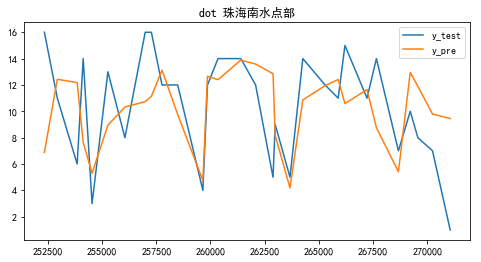

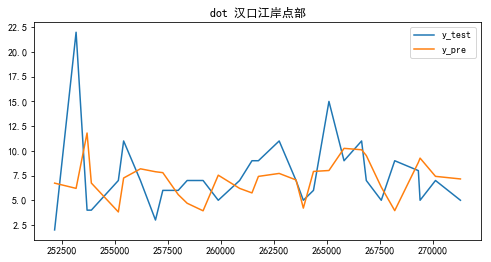

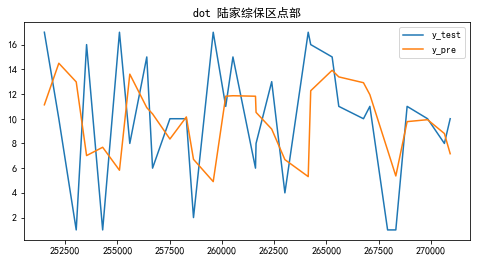

In [48]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_test','y_pre']
L = np.random.randint( low = 0, high = 648, size = 3 )
for i in L:
    s1 = pd.DataFrame(result[result['dot'] == result['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(result['dot'].unique()[i]), figsize = (8,4))

## 预测方式2

In [76]:
def pre_feature(data, dot_name):
    x_test_tmp = pd.DataFrame()
    rolling_tmp = pd.DataFrame()
    for dot in dot_name['dot']:
        # lagging
        dot_test = data.loc[data['dot'] == dot]
        dot_test_ts = dot_test.copy()
        dot_test['lagging7'] = dot_test['lagging6']
        dot_test['lagging6'] = dot_test['lagging5']
        dot_test['lagging5'] = dot_test['lagging4']
        dot_test['lagging4'] = dot_test['lagging3']
        dot_test['lagging3'] = dot_test['lagging2']
        dot_test['lagging2'] = dot_test['lagging1']
        dot_test['lagging1'] = dot_test['order_num']

        x_test_tmp = pd.concat([x_test_tmp, dot_test])

        # rolling
        dot_test_ts.index = pd.to_datetime(dot_test_ts['order_date'])
        num_ts = dot_test_ts.loc[dot_test_ts['dot'] == dot, ['order_num']]
        rolling = pd.concat([num_ts.rolling(window = 3).mean(), num_ts.rolling(window = 5).mean(), num_ts.rolling(window = 7).mean()], axis = 1)
    #     rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling_tmp = pd.concat([rolling_tmp, rolling])

    x_test = pd.merge(x_test_tmp.drop(['rolling3', 'rolling5', 'rolling7'], axis = 1), rolling_tmp, how = 'left', on = ['dot', 'order_date'])
    x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = 1)
    x_test.dropna(axis = 0, inplace = True)
    
    return x_test

In [ ]:
print("START : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
result_to_csv = pd.DataFrame()
org_test = dot_train.copy()
feature = ['dot', 'city_code', 'order_date', 'dot_id', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', '大点部',
       '小点部', '航空组', '京津冀', '华东', '华北', '华南', '上海', '北京', '四川省', '天津', '安徽省',
       '山东省', '广东省', '广西', '江苏省', '江西省', '河北省', '河南省', '浙江省', '湖北省', '福建省',
       '贵州省', '辽宁省']
feature_num = ['dot', 'city_code', 'order_date', 'dot_id', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', '大点部',
       '小点部', '航空组', '京津冀', '华东', '华北', '华南', '上海', '北京', '四川省', '天津', '安徽省',
       '山东省', '广东省', '广西', '江苏省', '江西省', '河北省', '河南省', '浙江省', '湖北省', '福建省',
       '贵州省', '辽宁省']
feature_date = ['dot', 'city_code', 'order_date', 'dot_id', 'order_num', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', '大点部',
       '小点部', '航空组', '京津冀', '华东', '华北', '华南', '上海', '北京', '四川省', '天津', '安徽省',
       '山东省', '广东省', '广西', '江苏省', '江西省', '河北省', '河南省', '浙江省', '湖北省', '福建省',
       '贵州省', '辽宁省']
for i in range(30):
    print(i)
    x_test = pre_feature(org_test, useful_dot_name)
    last_train_date = pd.to_datetime('2019-01-01') + pd.DateOffset(days = i + 1)
    x_test = x_test.loc[x_test['order_date'] == last_train_date, feature]#.drop(['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays'])
#     x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = i)
    
    x_test = time_feature(x_test)
    x_test = x_test[feature_num]

    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'order_num' : y_pre})
    result_to_csv = pd.concat([result_to_csv, result])
    x_test = pd.merge(x_test, result, on = ['dot', 'order_date'], how = 'left')
    x_test = x_test[feature_date]
    
    org_test = pd.concat([org_test, x_test])
print("END : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [78]:
org_test.columns

Index(['dot', 'city_code', 'order_date', 'dot_id', 'order_num', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', '大点部',
       '小点部', '航空组', '京津冀', '华东', '华北', '华南', '上海', '北京', '四川省', '天津', '安徽省',
       '山东省', '广东省', '广西', '江苏省', '江西省', '河北省', '河南省', '浙江省', '湖北省', '福建省',
       '贵州省', '辽宁省'],
      dtype='object')

In [ ]:
result_to_csv['order_num'] = np.expm1(result_to_csv['order_num'])
result_to_csv.head()

In [ ]:
org_data = dot_data.copy()
org_data['order_num'] = np.expm1(org_data['order_num'])
org_data.tail()

In [ ]:
r1 = pd.merge(result_to_csv, org_data, on = ['dot', 'order_date'], how = 'left')
r1 = r1[['dot', 'order_date', 'order_num_x', 'dot_id', 'order_num_y']]
r1.columns = ['dot', 'order_date', 'y_pre', 'dot_id', 'y_test']
r1 = r1[['dot', 'order_date', 'dot_id', 'y_test', 'y_pre']]
r1.head()

In [ ]:
print("MAE : ", MAE(r1.y_test, r1.y_pre))
print("RMSE : ", RMSE(r1.y_test, r1.y_pre))

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_pre','y_test']
L = np.random.randint( low = 0, high = 183, size = 3 )
for i in L:
    s1 = pd.DataFrame(r1[r1['dot'] == r1['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(r1['dot'].unique()[i]), figsize = (8,4))